# Imports

In [1]:
config = {
    'GRANDE': {
        'split_index_activation': 'entmax',  
        'normalize_index_array': False,
        'split_decision_activation': 'softsign', # sigmoid | softsign
        
        'depth': 6,
        'n_estimators': 2048,
                
        'learning_rate_weights': 0.005,
        'learning_rate_index': 0.01,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.01,   

        'fine_tune': False,
        'cosine_decay_steps': 0,        
        
        'reduce_lr': False,
        'reduce_lr_each_eval_nums': 10,
        'reduce_lr_fraction': 0.2,
        
        'dropout': 0,#0.25,
        
        'selected_variables': 0.8, #int number or float fraction
        'data_subset_fraction': 1.0,
        'bootstrap': False,
                
        'initializer': 'RandomNormal', 
        
        'optimizer': 'SWA', 
        
        'epochs': 10_000,
        'batch_size': 64,#512
        'drop_remainder': True,
        
        
        'loss': 'focal_crossentropy', 
        'focalLossGamma': 2.0,
        
        'transformation_type': 'mean', #for regression; mean log       
        
        'polyLoss': False,
        'polyLossEpsilon': 2.0,
        
        'weight_activation_st': 'softmax',
        'estimator_leaf_weights': True,

        'modify_grads': False,
        
        'logit_weights': False,
        #'weight_freeze_steps': 0,
        'warmup_steps': 0,
        
        'restarts': 0,
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 25,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 1e-3,
        
        'class_weights': True,

        'model_seed': 1,
    },
    
    'preprocessing': {
        'balance_threshold': 0,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'quantile', #'min-max'
        'encoding_type': 'LOO', #GLMM
        'one_hot_encode_threshold': 10,
        'quantile_noise': 1e-3,

        'XGBoostEncoding': False,
        'CatBoostEncoding': True,
    },

    'computation': {
        'random_seed': 42,
        'cv_num_eval': 5,
        'subset_size': None, # medium: 10_000, large: 50_000, keep normal size: None
        
        'use_best_hpo_result': False,# True,
        'hpo_path': '_DEFAULT',
        
        'force_depth': False,
        'force_dropout': False,
        'force_class_weights': False,
        'force_restart': True,
        
        'use_gpu': True,
        'gpu_numbers': '0,1',
        
        'parallel_jobs_cv': 1,
        'jobs_per_gpu': 3,
                
        'search_iterations': 60,
        'cv_num_hpo': 2,     
        'report_test_performance': False,
        
        'metrics_class': ['f1', 'balanced_accuracy', 'roc_auc'],
        'metrics_reg': ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        
        'eval_metric_class': ['f1', 'balanced_accuracy', 'roc_auc'],
        'eval_metric_reg': ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],

        'max_hours': 2.0,        
    },
    
    'benchmarks': {          
        'CART': False,
        'RandomForest': False,
        
        'XGB': True,
        'CatBoost': True,
        'NODE': True,
    }
}

In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:512"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"

import logging
logging.getLogger("ray").setLevel(logging.ERROR)
logging.getLogger("worker").setLevel(logging.ERROR)

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K

import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GRANDE import *
from utilities.GRANDE import *


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

import joblib
import ray
from ray.util.joblib import register_ray
register_ray()
from ray.autoscaler.sdk import request_resources
ray.init()

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results" + config['computation']['hpo_path'] + "/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results' + config['computation']['hpo_path'] + '/depth' + str(config['GRANDE']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)     


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

WARNING! The apex is not installed so fp16 is not available.


2023-09-25 07:09:31,518	INFO worker.py:1621 -- Started a local Ray instance.


2023-09-25--05-09-36244038


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
config['computation']['number_of_gpus'] = len(tf.config.experimental.list_physical_devices('GPU'))

config['computation']['n_jobs'] = config['computation']['jobs_per_gpu']*config['computation']['parallel_jobs_cv']

Num GPUs Available:  2
Num XLA-GPUs Available:  2


# Evaluation

## Real-World Eval

In [8]:
#BS Datasets
#https://github.com/openml/benchmark-suites/blob/44bb11328ef4ae79c67e02ffaf179bd633a5b20b/OpenML%20Benchmark%20generator.ipynb#L1038

identifier_list = [
                        'BIN:CC18_wilt', #40983                                                4,839 |      5 
                        'BIN:CC18_phoneme', #1489                                              5,404 |      5        
                        'BIN:CC18_Amazon_employee_access', #4135                              32,769 |      9              
                        'BIN:CC18_ilpd', #1480                                                   583 |     10 
                        'BIN:CC18_dresses-sales', #23381                                         500 |     12
                        'BIN:CC18_adult', #1590                                               48,842 |     14
                        'BIN:CC18_climate-model-simulation-crashes', #40994                      540 |     18                   
                        'BIN:CC18_churn', #40701                                               5,000 |     20 
                        'BIN:CC18_numerai28.6', #23517                                        96,320 |     21
                        'BIN:CC18_wdbc', #1510                                                   569 |     30 
                        'BIN:CC18_PhishingWebsites', #4534                                    11,055 |     30     
                        'BIN:CC18_cylinder-bands', #6332                                         540 |     37
                        'BIN:CC18_qsar-biodeg', #1494                                          1,055 |     41
                        'BIN:CC18_tokyo1', #40705                                                959 |     44 
                        'BIN:CC18_ozone-level-8hr', #1487                                      2,534 |     72           
                        'BIN:CC18_nomao', #1486                                               34,465 |    118
                        'BIN:CC18_SpeedDating', #40536                                         8,378 |    120
                        'BIN:CC18_madelon', #1485                                              2,600 |    500 
                        'BIN:CC18_Bioresponse', #4134                                          3,751 |  1,776                        
                  ]       

In [9]:
string_identifier = 'regression' if 'REG:' in identifier_list[0] else 'classification'
string_identifier_short = 'reg' if 'REG:' in identifier_list[0] else 'class'
string_identifier_specific = 'regression' if 'REG:' in identifier_list[0] else 'binary' if 'BIN:' in identifier_list[0] else 'multi'


benchmark_dict = get_benchmark_dict(config=config, eval_identifier=string_identifier) 

print('Parallel CV Jobs Nested:', config['computation']['parallel_jobs_cv'])
print('Parallel Jobs per GPU:', config['computation']['jobs_per_gpu'])
#jobs_per_gpu = jobs_per_gpu // 2 if config['computation']['report_test_performance'] else jobs_per_gpu
#jobs_per_gpu = int(np.ceil(jobs_per_gpu/2)) if config['computation']['cv_num'] > 1
n_jobs = config['computation']['jobs_per_gpu']*config['computation']['number_of_gpus'] #not more than 3 jobs per GPU
num_gpu = 1/(np.ceil(n_jobs/config['computation']['number_of_gpus']))  

with open(os.devnull, "w") as f, contextlib.redirect_stderr(f):
    with joblib.parallel_backend('ray', ray_remote_args=dict(num_gpus=num_gpu)):#ray_remote_args=dict(num_gpus=1) #, 'num_cpus':1 #, ray_remote_args={'num_gpus':num_gpu}
        parallel_eval_real_world_nested = Parallel(n_jobs = n_jobs, verbose=30) #loky #sequential multiprocessing
        evaluation_results_real_world_nested = parallel_eval_real_world_nested(delayed(evaluate_GRANDE)(identifier,
                                                                                                     timestr,
                                                                                                     dataset_dict_list = None,
                                                                                                      random_seed_data=config['computation']['random_seed'], 
                                                                                                      random_seed_model=config['computation']['random_seed'], 
                                                                                                      config=config,
                                                                                                      benchmark_dict_list=[benchmark_dict for _ in range(config['computation']['cv_num_eval'])],
                                                                                                      metrics=config['computation']['metrics_' + string_identifier_short],
                                                                                                      verbosity=-1,
                                                                                                      parallel_jobs_cv=config['computation']['parallel_jobs_cv'],
                                                                                                      parallel_jobs_parent=config['computation']['jobs_per_gpu']) for identifier in identifier_list)    


evaluation_results_real_world = [[{}, {}, {}] for _ in range(config['computation']['cv_num_eval'])]

for i in range(config['computation']['cv_num_eval']):
    for evaluation_results_by_identifier in evaluation_results_real_world_nested:
        identifier = evaluation_results_by_identifier[i][0]
        evaluation_results_real_world[i][0][identifier] = evaluation_results_by_identifier[i][1]
        evaluation_results_real_world[i][1][identifier] = evaluation_results_by_identifier[i][3]
        evaluation_results_real_world[i][2][identifier] = evaluation_results_by_identifier[i][2]



Parallel CV Jobs Nested: 1
Parallel Jobs per GPU: 3


2023-09-25 07:09:37,279	WARNING pool.py:589 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


(PoolActor pid=1477167) WARNING! The apex is not installed so fp16 is not available.
(PoolActor pid=1477167) START BIN:CC18_Amazon_employee_access
(PoolActor pid=1477169) END BIN:CC18_dresses-sales
(PoolActor pid=1477166) WARNING! The apex is not installed so fp16 is not available. [repeated 5x across cluster]
(PoolActor pid=1477169) START BIN:CC18_PhishingWebsites [repeated 6x across cluster]
(PoolActor pid=1477167) END BIN:CC18_Amazon_employee_access
(PoolActor pid=1477167) START BIN:CC18_numerai28.6
(PoolActor pid=1477168) END BIN:CC18_ilpd
(PoolActor pid=1477168) START BIN:CC18_wdbc
(PoolActor pid=1477165) END BIN:CC18_wilt
(PoolActor pid=1477165) START BIN:CC18_climate-model-simulation-crashes
(PoolActor pid=1477167) END BIN:CC18_numerai28.6
(PoolActor pid=1477167) START BIN:CC18_ozone-level-8hr
(PoolActor pid=1477168) END BIN:CC18_wdbc
(PoolActor pid=1477168) START BIN:CC18_nomao
(PoolActor pid=1477166) END BIN:CC18_phoneme
(PoolActor pid=1477166) START BIN:CC18_churn
(PoolActor 

In [10]:
identifier = identifier_list[0]
if 'REG:' in identifier:
    config['GRANDE']['objective'] = 'regression'   
    eval_metric = 'r2'#config['computation']['metrics_reg'][0]
    clip_negative = False #True
    quantile = 0.1 #0.5
elif 'BIN:' in identifier:
    config['GRANDE']['objective'] = 'classification'   
    eval_metric = 'f1'#config['computation']['metrics_class'][0]
    clip_negative = False
    quantile = 0.1  
elif 'MULT:' in identifier:
    config['GRANDE']['objective'] = 'classification'   
    eval_metric = 'f1'#config['computation']['metrics_class'][0]
    clip_negative = False
    quantile = 0.1   

identifier_list_samples = sort_dataset_identifiers(identifier_list, config, by='samples')
identifier_list_features = sort_dataset_identifiers(identifier_list, config, by='features')



In [11]:
result_dataframe_dict_samples = {}

result_dataframe_dict_samples['test'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                    evaluation_results_real_world=evaluation_results_real_world,
                                    identifier_list=identifier_list_samples,                            
                                    identifier_string=string_identifier_specific + '_test',
                                    filepath=filepath,
                                    plot_runtime=True,
                                    config=config)      

result_dataframe_dict_samples['valid'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                    evaluation_results_real_world=evaluation_results_real_world,
                                    identifier_list=identifier_list_samples,                            
                                    identifier_string=string_identifier_specific + '_valid',
                                    filepath=filepath,
                                    config=config)  

result_dataframe_dict_samples['train'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                    evaluation_results_real_world=evaluation_results_real_world,
                                    identifier_list=identifier_list_samples,                            
                                    identifier_string=string_identifier_specific + '_train',
                                    filepath=filepath,
                                    config=config)  

,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_dresses-sales,0.595877,0.013982,0.570137,0.055772,0.573186,0.030651,0.559034,0.045072
BIN:CC18_climate-model-simulation-crashes,0.757919,0.064567,0.780980,0.060497,0.780775,0.049595,0.765525,0.088223
BIN:CC18_cylinder-bands,0.812852,0.023252,0.769597,0.010204,0.795249,0.051132,0.696027,0.027966
BIN:CC18_wdbc,0.962301,0.008226,0.966067,0.022637,0.955211,0.029499,0.964315,0.017115
BIN:CC18_ilpd,0.646337,0.020709,0.629056,0.051882,0.643471,0.041911,0.500688,0.085332
BIN:CC18_tokyo1,0.921997,0.013870,0.917015,0.016150,0.917199,0.013303,0.920645,0.010895
BIN:CC18_qsar-biodeg,0.851273,0.032281,0.844027,0.021248,0.842784,0.016930,0.837852,0.026547
BIN:CC18_ozone-level-8hr,0.735389,0.011378,0.685900,0.033671,0.702368,0.029479,0.661766,0.019348
BIN:CC18_madelon,0.768311,0.022425,0.811111,0.015706,0.851113,0.014727,0.649733,0.016558
BIN:CC18_Bioresponse,0.789154,0.013776,0.788885,0.013137,0.792291,0.004173,0.786402,0.009701


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_dresses-sales,0.600575,0.013167,0.572742,0.053993,0.574384,0.031896,0.576108,0.038184
BIN:CC18_climate-model-simulation-crashes,0.728736,0.083902,0.766100,0.035059,0.775079,0.051689,0.713737,0.089016
BIN:CC18_cylinder-bands,0.811719,0.024010,0.769511,0.012045,0.792641,0.049227,0.693387,0.026956
BIN:CC18_wdbc,0.960552,0.007985,0.963421,0.022910,0.956954,0.029076,0.963866,0.017054
BIN:CC18_ilpd,0.687593,0.024884,0.659154,0.048171,0.673427,0.043003,0.540735,0.048076
BIN:CC18_tokyo1,0.927763,0.011219,0.920726,0.017734,0.921329,0.012046,0.918943,0.008322
BIN:CC18_qsar-biodeg,0.852911,0.037238,0.847231,0.025104,0.850611,0.021603,0.832707,0.032603
BIN:CC18_ozone-level-8hr,0.736276,0.017196,0.760788,0.022193,0.794319,0.023328,0.619735,0.019831
BIN:CC18_madelon,0.768462,0.022281,0.811154,0.015689,0.851154,0.014726,0.650000,0.016588
BIN:CC18_Bioresponse,0.789091,0.014278,0.789369,0.013532,0.792220,0.003579,0.786101,0.010188


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_dresses-sales,0.619253,0.046597,0.590066,0.037902,0.595197,0.022323,0.637110,0.039923
BIN:CC18_climate-model-simulation-crashes,0.948127,0.038374,0.929984,0.031303,0.939250,0.031887,0.934781,0.030344
BIN:CC18_cylinder-bands,0.894600,0.023068,0.846527,0.023458,0.889954,0.044829,0.808338,0.016916
BIN:CC18_wdbc,0.994602,0.004093,0.991283,0.010318,0.989376,0.012294,0.991896,0.006423
BIN:CC18_ilpd,0.758561,0.055498,0.716347,0.046185,0.730900,0.053845,0.748102,0.041767
BIN:CC18_tokyo1,0.983399,0.005710,0.978986,0.007209,0.981436,0.004103,0.979987,0.006509
BIN:CC18_qsar-biodeg,0.934207,0.014231,0.929169,0.010525,0.934371,0.007416,0.921517,0.003521
BIN:CC18_ozone-level-8hr,0.918582,0.023798,0.871216,0.030622,0.908968,0.010382,0.919256,0.019060
BIN:CC18_madelon,0.848160,0.025043,0.887121,0.015964,0.915376,0.010731,0.725426,0.014711
BIN:CC18_Bioresponse,0.868121,0.005926,0.863738,0.011160,0.870411,0.005164,0.867287,0.006181


,GRANDE Mean Runtime,GRANDE Std Runtime,XGB Mean Runtime,XGB Std Runtime,CatBoost Mean Runtime,CatBoost Std Runtime,NODE Mean Runtime,NODE Std Runtime
BIN:CC18_dresses-sales,26.534000,7.000000,1.388000,1.000000,42.400000,27.000000,147.118000,86.000000
BIN:CC18_climate-model-simulation-crashes,55.697000,24.000000,1.448000,1.000000,444.752000,470.000000,654.143000,101.000000
BIN:CC18_cylinder-bands,53.267000,13.000000,0.659000,0.000000,818.649000,532.000000,306.926000,187.000000
BIN:CC18_wdbc,116.692000,33.000000,1.882000,1.000000,214.604000,87.000000,496.694000,74.000000
BIN:CC18_ilpd,30.156000,8.000000,1.113000,0.000000,36.980000,28.000000,296.109000,110.000000
BIN:CC18_tokyo1,36.086000,4.000000,0.694000,0.000000,378.053000,187.000000,532.503000,236.000000
BIN:CC18_qsar-biodeg,51.742000,11.000000,0.548000,0.000000,526.100000,173.000000,713.437000,408.000000
BIN:CC18_ozone-level-8hr,127.123000,18.000000,1.012000,0.000000,98.898000,36.000000,544.311000,89.000000
BIN:CC18_madelon,59.183000,7.000000,0.934000,0.000000,402.281000,135.000000,849.741000,180.000000
BIN:CC18_Bioresponse,56.259000,5.000000,1.775000,0.000000,619.031000,261.000000,2650.835000,549.000000


,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_dresses-sales,0.554213,0.023601,0.578388,0.073941,0.564261,0.045643,0.546437,0.063629
BIN:CC18_climate-model-simulation-crashes,0.879378,0.060699,0.843090,0.134834,0.875674,0.103849,0.849663,0.119899
BIN:CC18_cylinder-bands,0.813404,0.033741,0.761238,0.030761,0.810338,0.044392,0.675369,0.089180
BIN:CC18_wdbc,0.995275,0.009450,0.995275,0.009450,0.981333,0.017459,0.976727,0.020864
BIN:CC18_ilpd,0.646528,0.047001,0.637640,0.053741,0.618347,0.089019,0.525256,0.088088
BIN:CC18_tokyo1,0.923352,0.024887,0.917521,0.017016,0.931073,0.022567,0.949802,0.038905
BIN:CC18_qsar-biodeg,0.886011,0.033338,0.865763,0.040990,0.870106,0.035691,0.865047,0.037253
BIN:CC18_ozone-level-8hr,0.788355,0.052703,0.697318,0.041104,0.724076,0.054029,0.660319,0.091701
BIN:CC18_madelon,0.759313,0.023807,0.798830,0.026603,0.846083,0.019240,0.661152,0.028336
BIN:CC18_Bioresponse,0.783582,0.022442,0.786414,0.006390,0.803422,0.008419,0.779329,0.026649


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_dresses-sales,0.555754,0.023224,0.582353,0.076754,0.564450,0.045905,0.568798,0.045510
BIN:CC18_climate-model-simulation-crashes,0.845000,0.053968,0.875000,0.111524,0.907500,0.109144,0.820000,0.130528
BIN:CC18_cylinder-bands,0.813474,0.037051,0.765474,0.031979,0.810737,0.043469,0.676421,0.084637
BIN:CC18_wdbc,0.994118,0.011765,0.994118,0.011765,0.981339,0.017875,0.977890,0.021005
BIN:CC18_ilpd,0.692522,0.065161,0.663661,0.062308,0.653706,0.108283,0.558128,0.050480
BIN:CC18_tokyo1,0.933673,0.021036,0.926531,0.015593,0.938265,0.019983,0.951020,0.037402
BIN:CC18_qsar-biodeg,0.888177,0.027619,0.870567,0.040378,0.879002,0.028213,0.867241,0.034821
BIN:CC18_ozone-level-8hr,0.799069,0.040284,0.786559,0.051566,0.832186,0.041196,0.619919,0.078780
BIN:CC18_madelon,0.759615,0.023553,0.799038,0.026403,0.846154,0.019231,0.661538,0.028296
BIN:CC18_Bioresponse,0.783524,0.022452,0.786967,0.007044,0.804231,0.008476,0.779059,0.026483


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_dresses-sales,0.564706,0.040451,0.628389,0.087473,0.601279,0.059960,0.619949,0.071659
BIN:CC18_climate-model-simulation-crashes,0.981250,0.019764,0.973125,0.030208,0.983750,0.023251,0.948750,0.054112
BIN:CC18_cylinder-bands,0.909474,0.037091,0.837895,0.049677,0.895158,0.040197,0.780211,0.069245
BIN:CC18_wdbc,1.000000,0.000000,0.997972,0.004057,0.998377,0.003245,0.998783,0.001623
BIN:CC18_ilpd,0.720094,0.058755,0.723659,0.086272,0.712218,0.102188,0.725802,0.066588
BIN:CC18_tokyo1,0.989504,0.005842,0.985277,0.007856,0.989067,0.009254,0.989504,0.006331
BIN:CC18_qsar-biodeg,0.953818,0.018628,0.938547,0.030678,0.948522,0.015875,0.933621,0.023381
BIN:CC18_ozone-level-8hr,0.948664,0.021783,0.885304,0.041979,0.935142,0.023710,0.937976,0.025069
BIN:CC18_madelon,0.847947,0.018072,0.871635,0.022069,0.911354,0.011606,0.739090,0.038755
BIN:CC18_Bioresponse,0.871090,0.009157,0.870577,0.012405,0.874633,0.011307,0.865810,0.007851


,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_dresses-sales,0.736308,0.040092,0.815602,0.045543,0.716751,0.019246,0.661896,0.053290
BIN:CC18_climate-model-simulation-crashes,0.995099,0.009801,0.979624,0.036805,0.990579,0.018843,0.853436,0.021523
BIN:CC18_cylinder-bands,0.994702,0.006711,0.997891,0.004218,0.985648,0.015945,0.815643,0.025365
BIN:CC18_wdbc,0.998957,0.001278,1.000000,0.000000,0.998956,0.002088,0.975384,0.003135
BIN:CC18_ilpd,0.752759,0.020331,0.828422,0.025299,0.819410,0.060006,0.540502,0.092430
BIN:CC18_tokyo1,0.948493,0.004505,0.995300,0.000987,0.981259,0.010565,0.926540,0.007621
BIN:CC18_qsar-biodeg,0.968227,0.012898,0.984837,0.009989,0.964574,0.027980,0.856763,0.008363
BIN:CC18_ozone-level-8hr,0.967622,0.030538,0.862111,0.038258,0.842519,0.047638,0.787160,0.044212
BIN:CC18_madelon,0.994124,0.001941,0.991346,0.007512,0.958547,0.033179,0.997543,0.002736
BIN:CC18_Bioresponse,0.898388,0.019284,0.970272,0.024270,0.931798,0.022739,0.896169,0.014593


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_dresses-sales,0.736164,0.041304,0.817849,0.046852,0.717615,0.017550,0.668931,0.044064
BIN:CC18_climate-model-simulation-crashes,0.999157,0.001685,0.996067,0.007183,0.998315,0.003371,0.791582,0.020943
BIN:CC18_cylinder-bands,0.994380,0.007168,0.998051,0.003898,0.984637,0.017139,0.809498,0.026389
BIN:CC18_wdbc,0.998957,0.001344,1.000000,0.000000,0.998956,0.002088,0.974253,0.003480
BIN:CC18_ilpd,0.800225,0.020829,0.882505,0.021300,0.861250,0.055413,0.568213,0.057406
BIN:CC18_tokyo1,0.954505,0.004798,0.996601,0.000719,0.983778,0.009804,0.923409,0.007552
BIN:CC18_qsar-biodeg,0.972957,0.011019,0.988704,0.007585,0.971906,0.023353,0.850050,0.009289
BIN:CC18_ozone-level-8hr,0.989007,0.007344,0.975845,0.009726,0.970237,0.012621,0.720452,0.042833
BIN:CC18_madelon,0.994124,0.001941,0.991346,0.007512,0.958547,0.033179,0.997543,0.002736
BIN:CC18_Bioresponse,0.898640,0.019976,0.970617,0.023893,0.932221,0.022736,0.895754,0.014746


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_dresses-sales,0.800811,0.038117,0.895912,0.048108,0.797687,0.027037,0.789306,0.015360
BIN:CC18_climate-model-simulation-crashes,1.000000,0.000000,0.999535,0.000930,1.000000,0.000000,0.986079,0.005423
BIN:CC18_cylinder-bands,0.999564,0.000618,0.999951,0.000098,0.998206,0.003006,0.914340,0.024159
BIN:CC18_wdbc,0.999995,0.000010,1.000000,0.000000,0.999990,0.000020,0.995533,0.000892
BIN:CC18_ilpd,0.875985,0.022529,0.959175,0.021308,0.940753,0.050145,0.773019,0.019763
BIN:CC18_tokyo1,0.991522,0.001052,0.999891,0.000157,0.998129,0.001658,0.981872,0.001718
BIN:CC18_qsar-biodeg,0.993697,0.002351,0.999054,0.001086,0.993809,0.006487,0.939679,0.007328
BIN:CC18_ozone-level-8hr,0.998175,0.001067,0.996170,0.004192,0.996470,0.003654,0.967375,0.006556
BIN:CC18_madelon,0.999737,0.000091,0.999372,0.000640,0.991060,0.012989,0.999932,0.000115
BIN:CC18_Bioresponse,0.964575,0.011064,0.995462,0.005947,0.983506,0.008168,0.962533,0.008991


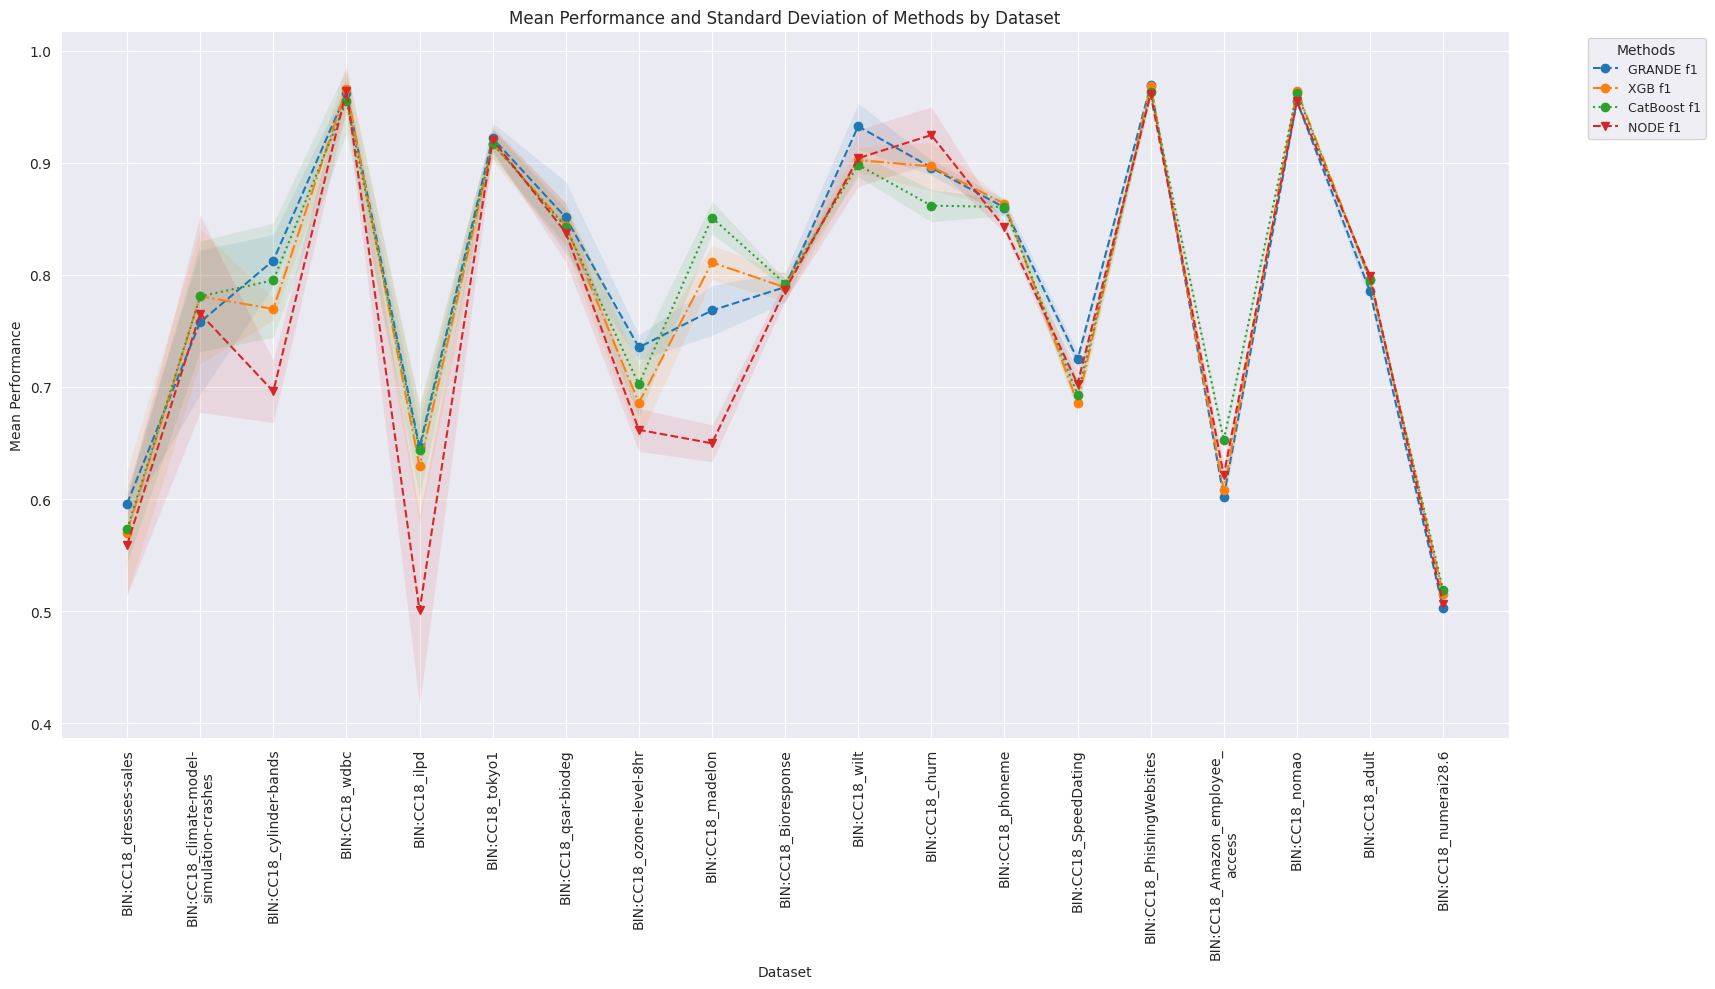

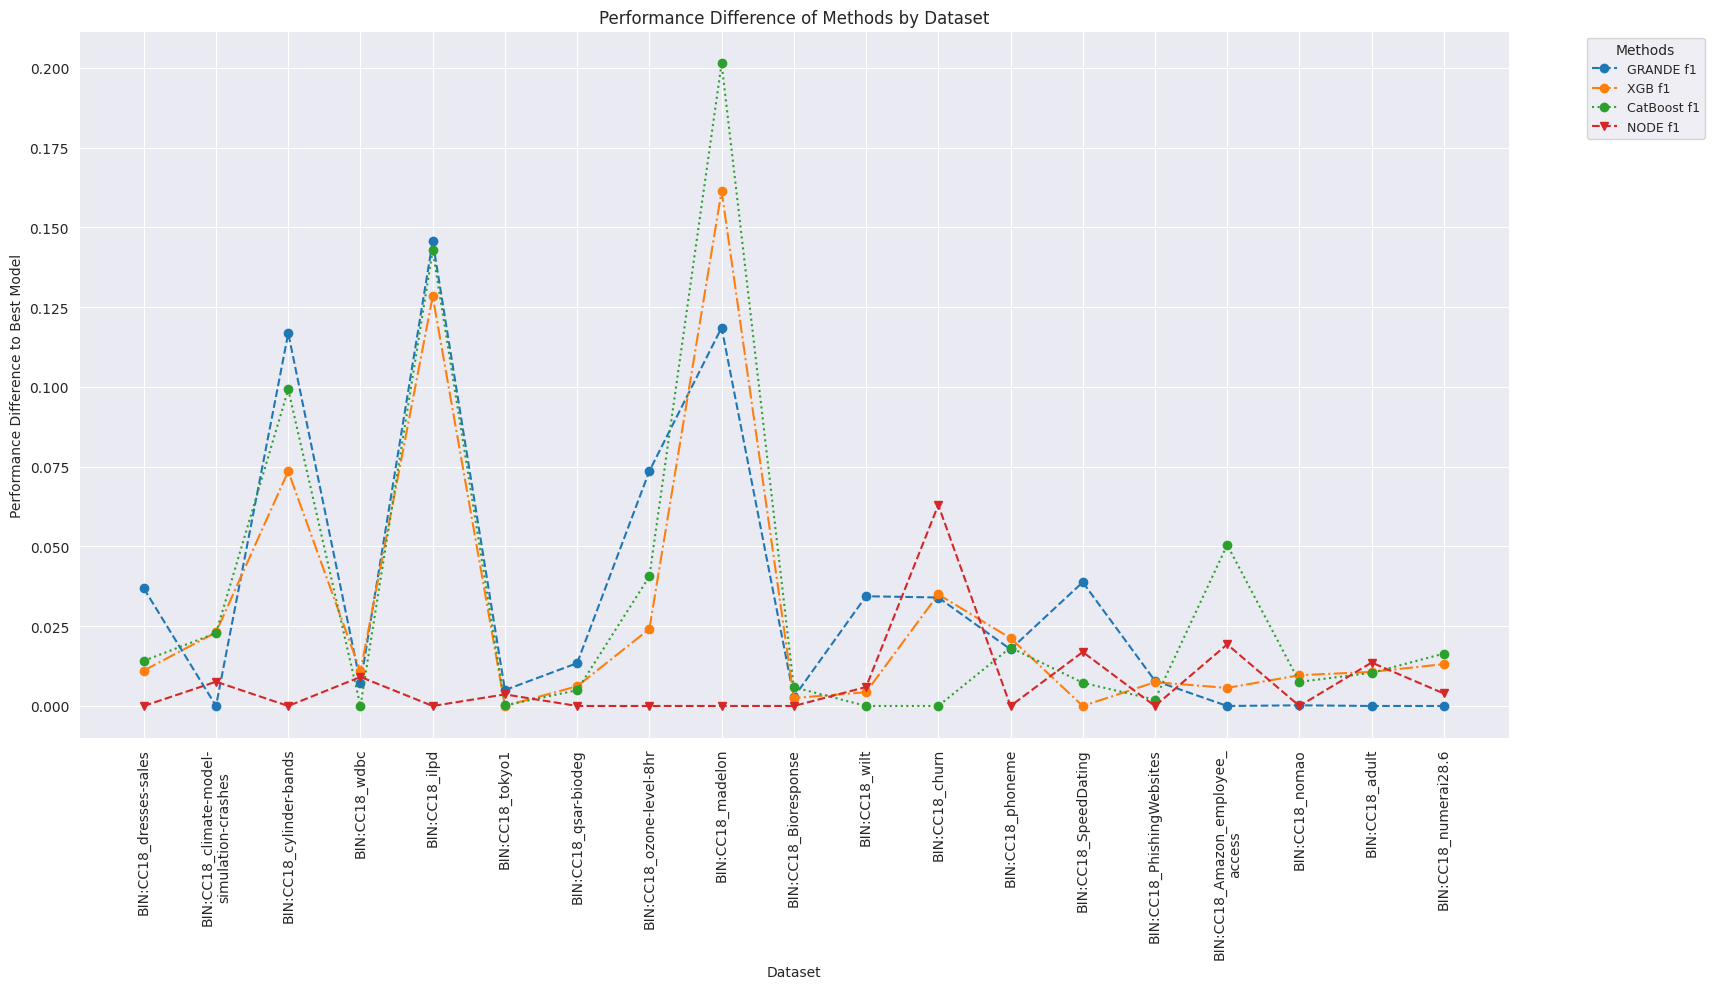

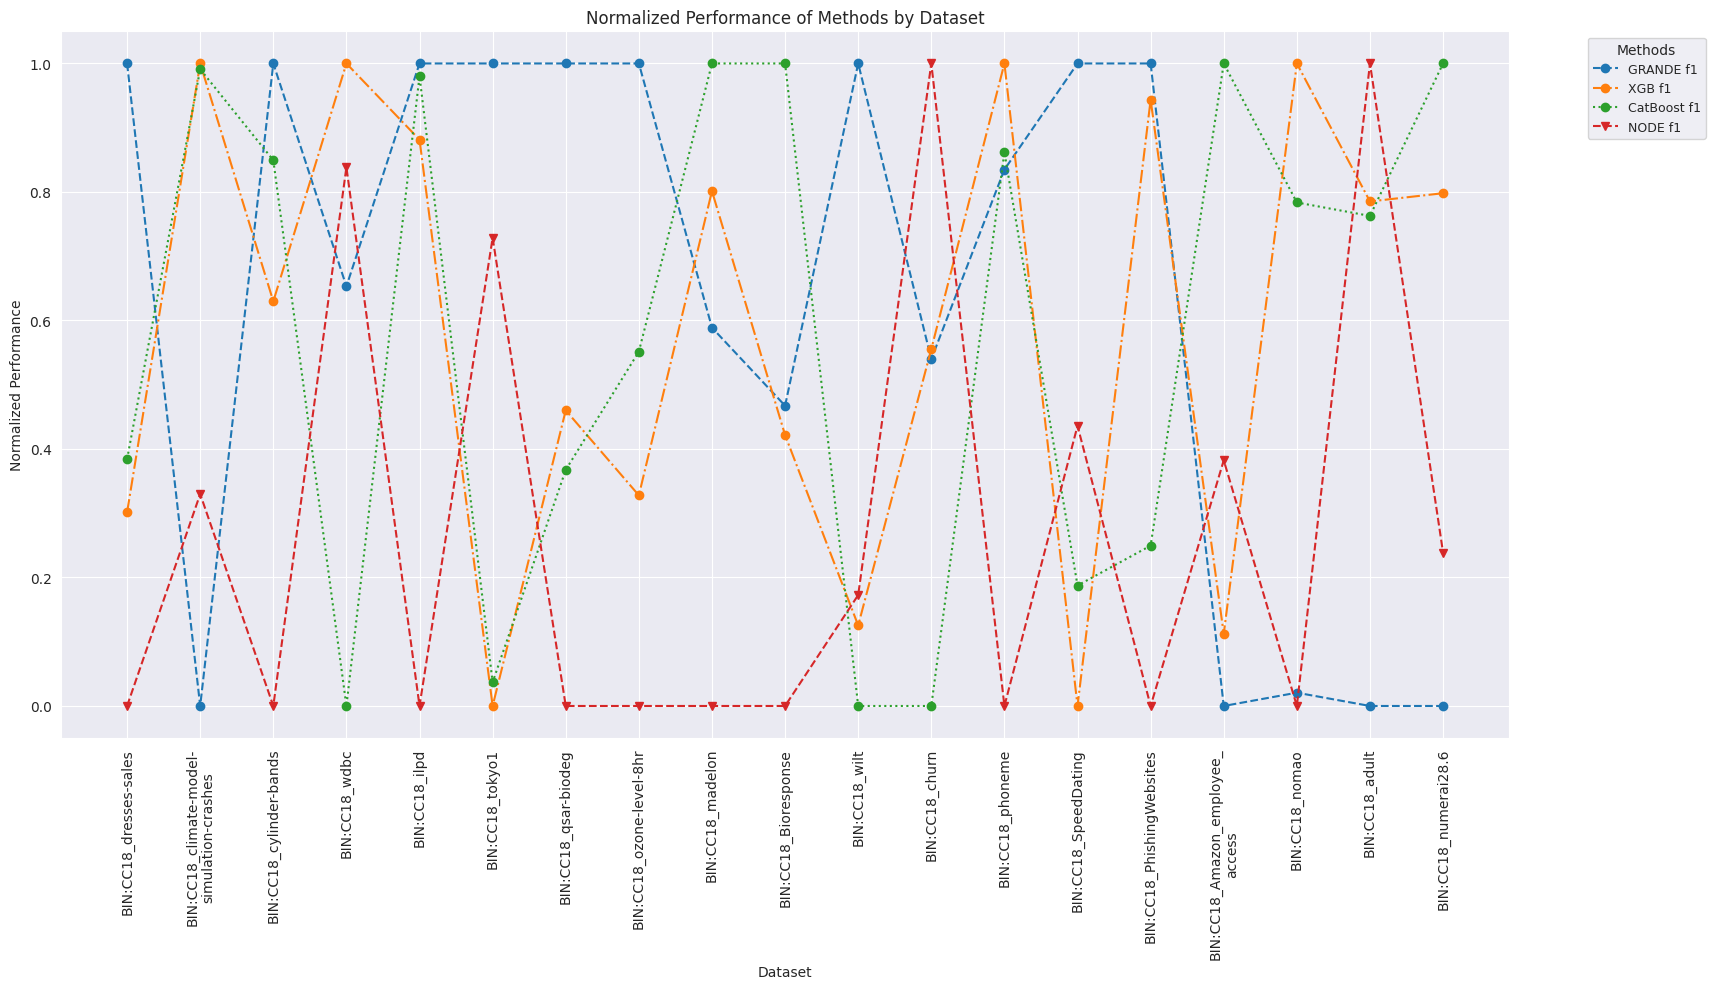

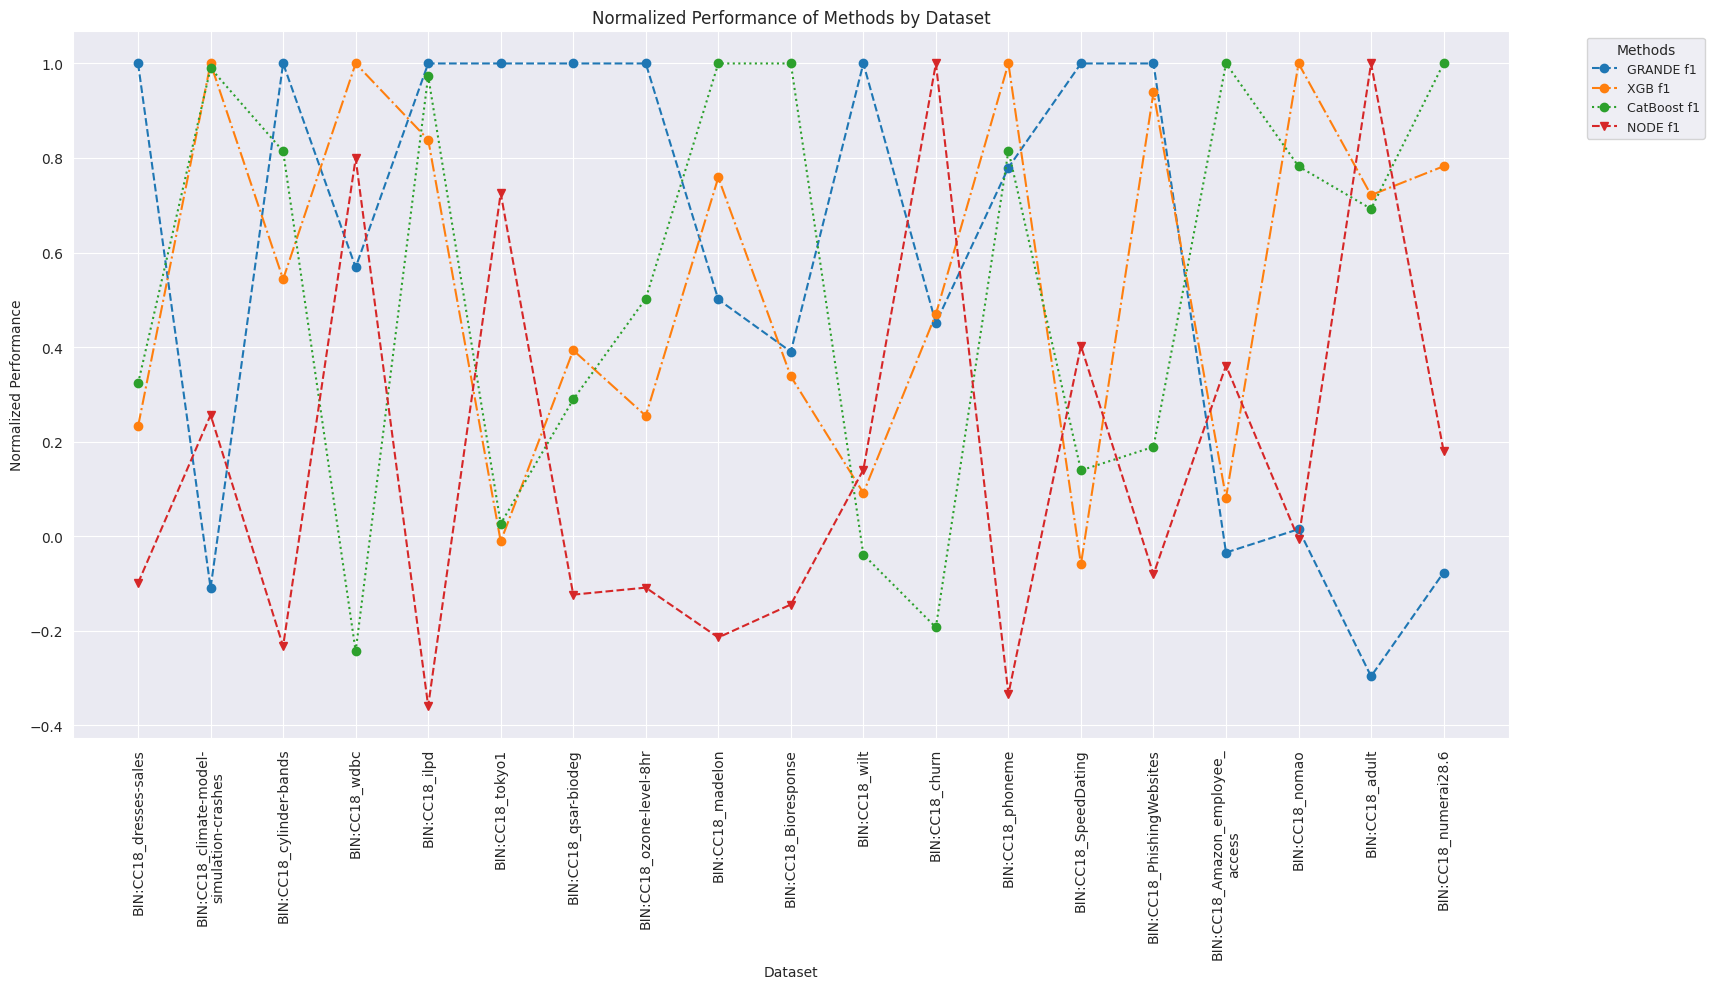

In [12]:
plot_methods_performance_with_std(result_dataframe_dict_samples['test'][eval_metric][:-3])
plot_methods_performance_diff(result_dataframe_dict_samples['test'][eval_metric][:-3])
plot_methods_performance_norm(result_dataframe_dict_samples['test'][eval_metric][:-3])
plot_methods_performance_norm_affine(result_dataframe_dict_samples['test'][eval_metric][:-3], quantile=quantile, clip_negative=clip_negative)

In [13]:
result_dataframe_dict_features = {}

result_dataframe_dict_features['test'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                            evaluation_results_real_world=evaluation_results_real_world,
                                            identifier_list=identifier_list_features,                            
                                            identifier_string=string_identifier_specific + '_test',
                                            filepath=filepath,
                                            plot_runtime=True,
                                            config=config)      

result_dataframe_dict_features['valid'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                            evaluation_results_real_world=evaluation_results_real_world,
                                            identifier_list=identifier_list_features,                            
                                            identifier_string=string_identifier_specific + '_valid',
                                            filepath=filepath,
                                            config=config)  

result_dataframe_dict_features['train'] = plot_table_save_results(benchmark_dict=benchmark_dict,
                                            evaluation_results_real_world=evaluation_results_real_world,
                                            identifier_list=identifier_list_features,                            
                                            identifier_string=string_identifier_specific + '_train',
                                            filepath=filepath,
                                            config=config)  

,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_wilt,0.932625,0.020762,0.902543,0.011388,0.898231,0.010773,0.904169,0.025542
BIN:CC18_phoneme,0.860090,0.008106,0.863601,0.003450,0.860664,0.007936,0.842345,0.004642
BIN:CC18_Amazon_employee_access,0.602008,0.006209,0.607670,0.016095,0.652491,0.005748,0.621310,0.010473
BIN:CC18_ilpd,0.646337,0.020709,0.629056,0.051882,0.643471,0.041911,0.500688,0.085332
BIN:CC18_climate-model-simulation-crashes,0.757919,0.064567,0.780980,0.060497,0.780775,0.049595,0.765525,0.088223
BIN:CC18_numerai28.6,0.502577,0.003459,0.515683,0.001908,0.518999,0.000548,0.506494,0.008978
BIN:CC18_churn,0.895802,0.007119,0.896793,0.021916,0.861807,0.014514,0.924792,0.025216
BIN:CC18_wdbc,0.962301,0.008226,0.966067,0.022637,0.955211,0.029499,0.964315,0.017115
BIN:CC18_dresses-sales,0.595877,0.013982,0.570137,0.055772,0.573186,0.030651,0.559034,0.045072
BIN:CC18_adult,0.785467,0.008256,0.796149,0.002874,0.795843,0.004526,0.799071,0.002665


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_wilt,0.961737,0.029479,0.953922,0.019388,0.951599,0.023527,0.862695,0.036169
BIN:CC18_phoneme,0.876754,0.007991,0.876698,0.005138,0.881162,0.005905,0.838800,0.006195
BIN:CC18_Amazon_employee_access,0.699642,0.010989,0.703191,0.010197,0.801831,0.015725,0.589173,0.009361
BIN:CC18_ilpd,0.687593,0.024884,0.659154,0.048171,0.673427,0.043003,0.540735,0.048076
BIN:CC18_climate-model-simulation-crashes,0.728736,0.083902,0.766100,0.035059,0.775079,0.051689,0.713737,0.089016
BIN:CC18_numerai28.6,0.509754,0.001617,0.516151,0.001809,0.520655,0.000624,0.518609,0.004121
BIN:CC18_churn,0.902147,0.010159,0.894805,0.024092,0.894766,0.011867,0.889211,0.033074
BIN:CC18_wdbc,0.960552,0.007985,0.963421,0.022910,0.956954,0.029076,0.963866,0.017054
BIN:CC18_dresses-sales,0.600575,0.013167,0.572742,0.053993,0.574384,0.031896,0.576108,0.038184
BIN:CC18_adult,0.825588,0.003309,0.844107,0.004411,0.844235,0.005174,0.781035,0.003503


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_wilt,0.992442,0.007467,0.989012,0.009989,0.992773,0.004775,0.990157,0.009100
BIN:CC18_phoneme,0.945719,0.006459,0.949637,0.006620,0.949121,0.009362,0.935067,0.005498
BIN:CC18_Amazon_employee_access,0.822806,0.009093,0.775104,0.012449,0.868948,0.014704,0.829127,0.015166
BIN:CC18_ilpd,0.758561,0.055498,0.716347,0.046185,0.730900,0.053845,0.748102,0.041767
BIN:CC18_climate-model-simulation-crashes,0.948127,0.038374,0.929984,0.031303,0.939250,0.031887,0.934781,0.030344
BIN:CC18_numerai28.6,0.515678,0.003496,0.520264,0.002438,0.528363,0.002549,0.527817,0.004222
BIN:CC18_churn,0.928965,0.014622,0.917219,0.014639,0.922256,0.014839,0.925311,0.015783
BIN:CC18_wdbc,0.994602,0.004093,0.991283,0.010318,0.989376,0.012294,0.991896,0.006423
BIN:CC18_dresses-sales,0.619253,0.046597,0.590066,0.037902,0.595197,0.022323,0.637110,0.039923
BIN:CC18_adult,0.913584,0.002745,0.928647,0.002265,0.926942,0.003115,0.918910,0.002984


,GRANDE Mean Runtime,GRANDE Std Runtime,XGB Mean Runtime,XGB Std Runtime,CatBoost Mean Runtime,CatBoost Std Runtime,NODE Mean Runtime,NODE Std Runtime
BIN:CC18_wilt,133.197000,41.000000,2.882000,1.000000,126.697000,108.000000,644.395000,106.000000
BIN:CC18_phoneme,145.199000,35.000000,1.737000,1.000000,406.481000,278.000000,857.062000,151.000000
BIN:CC18_Amazon_employee_access,117.496000,11.000000,1.147000,0.000000,165.144000,85.000000,55.725000,7.000000
BIN:CC18_ilpd,30.156000,8.000000,1.113000,0.000000,36.980000,28.000000,296.109000,110.000000
BIN:CC18_climate-model-simulation-crashes,55.697000,24.000000,1.448000,1.000000,444.752000,470.000000,654.143000,101.000000
BIN:CC18_numerai28.6,397.674000,71.000000,1.146000,0.000000,106.955000,29.000000,128.384000,79.000000
BIN:CC18_churn,97.118000,26.000000,0.706000,0.000000,263.466000,115.000000,516.977000,118.000000
BIN:CC18_wdbc,116.692000,33.000000,1.882000,1.000000,214.604000,87.000000,496.694000,74.000000
BIN:CC18_dresses-sales,26.534000,7.000000,1.388000,1.000000,42.400000,27.000000,147.118000,86.000000
BIN:CC18_adult,694.171000,221.000000,1.741000,1.000000,378.964000,143.000000,598.633000,116.000000


,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_wilt,0.932242,0.034741,0.881693,0.057620,0.903888,0.045832,0.897142,0.042198
BIN:CC18_phoneme,0.860464,0.010704,0.861082,0.016352,0.855564,0.011018,0.838803,0.016556
BIN:CC18_Amazon_employee_access,0.606652,0.018145,0.609664,0.012408,0.650977,0.010119,0.604591,0.024392
BIN:CC18_ilpd,0.646528,0.047001,0.637640,0.053741,0.618347,0.089019,0.525256,0.088088
BIN:CC18_climate-model-simulation-crashes,0.879378,0.060699,0.843090,0.134834,0.875674,0.103849,0.849663,0.119899
BIN:CC18_numerai28.6,0.504498,0.004095,0.515954,0.004194,0.519112,0.003200,0.506554,0.009344
BIN:CC18_churn,0.922468,0.018652,0.913886,0.014142,0.875175,0.019798,0.928031,0.007864
BIN:CC18_wdbc,0.995275,0.009450,0.995275,0.009450,0.981333,0.017459,0.976727,0.020864
BIN:CC18_dresses-sales,0.554213,0.023601,0.578388,0.073941,0.564261,0.045643,0.546437,0.063629
BIN:CC18_adult,0.783127,0.002392,0.791770,0.003532,0.791502,0.005770,0.797275,0.009197


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_wilt,0.942987,0.035105,0.913728,0.043846,0.943389,0.033131,0.855508,0.048582
BIN:CC18_phoneme,0.876936,0.012072,0.877724,0.017097,0.875184,0.015227,0.835603,0.019799
BIN:CC18_Amazon_employee_access,0.703846,0.026020,0.707449,0.020734,0.799494,0.017221,0.575617,0.019576
BIN:CC18_ilpd,0.692522,0.065161,0.663661,0.062308,0.653706,0.108283,0.558128,0.050480
BIN:CC18_climate-model-simulation-crashes,0.845000,0.053968,0.875000,0.111524,0.907500,0.109144,0.820000,0.130528
BIN:CC18_numerai28.6,0.512012,0.005051,0.516408,0.004391,0.520818,0.003082,0.518752,0.005255
BIN:CC18_churn,0.927814,0.014181,0.922265,0.012064,0.908562,0.014912,0.896205,0.009012
BIN:CC18_wdbc,0.994118,0.011765,0.994118,0.011765,0.981339,0.017875,0.977890,0.021005
BIN:CC18_dresses-sales,0.555754,0.023224,0.582353,0.076754,0.564450,0.045905,0.568798,0.045510
BIN:CC18_adult,0.823122,0.006932,0.840622,0.002166,0.840381,0.004617,0.778837,0.009446


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_wilt,0.984118,0.013732,0.976878,0.012728,0.979188,0.012733,0.980433,0.009667
BIN:CC18_phoneme,0.947635,0.008556,0.947609,0.007724,0.949298,0.007412,0.932325,0.006395
BIN:CC18_Amazon_employee_access,0.815634,0.020330,0.769914,0.025411,0.870265,0.013322,0.825141,0.015573
BIN:CC18_ilpd,0.720094,0.058755,0.723659,0.086272,0.712218,0.102188,0.725802,0.066588
BIN:CC18_climate-model-simulation-crashes,0.981250,0.019764,0.973125,0.030208,0.983750,0.023251,0.948750,0.054112
BIN:CC18_numerai28.6,0.520108,0.009181,0.521929,0.007649,0.529223,0.004667,0.526283,0.007921
BIN:CC18_churn,0.942642,0.009224,0.933901,0.014217,0.934223,0.011867,0.929344,0.010562
BIN:CC18_wdbc,1.000000,0.000000,0.997972,0.004057,0.998377,0.003245,0.998783,0.001623
BIN:CC18_dresses-sales,0.564706,0.040451,0.628389,0.087473,0.601279,0.059960,0.619949,0.071659
BIN:CC18_adult,0.911199,0.006077,0.925632,0.002780,0.923872,0.002848,0.917019,0.004107


,GRANDE f1_mean,GRANDE f1_std,XGB f1_mean,XGB f1_std,CatBoost f1_mean,CatBoost f1_std,NODE f1_mean,NODE f1_std
BIN:CC18_wilt,0.954166,0.009932,0.945876,0.018265,0.936303,0.030395,0.923271,0.006030
BIN:CC18_phoneme,0.916054,0.015744,0.958634,0.021227,0.921645,0.031237,0.881153,0.007973
BIN:CC18_Amazon_employee_access,0.756252,0.009313,0.762185,0.018465,0.759318,0.008743,0.799162,0.012658
BIN:CC18_ilpd,0.752759,0.020331,0.828422,0.025299,0.819410,0.060006,0.540502,0.092430
BIN:CC18_climate-model-simulation-crashes,0.995099,0.009801,0.979624,0.036805,0.990579,0.018843,0.853436,0.021523
BIN:CC18_numerai28.6,0.517974,0.011879,0.542610,0.013181,0.547311,0.004143,0.508692,0.007471
BIN:CC18_churn,0.978671,0.007622,0.961363,0.022992,0.892943,0.026727,0.950990,0.005019
BIN:CC18_wdbc,0.998957,0.001278,1.000000,0.000000,0.998956,0.002088,0.975384,0.003135
BIN:CC18_dresses-sales,0.736308,0.040092,0.815602,0.045543,0.716751,0.019246,0.661896,0.053290
BIN:CC18_adult,0.807569,0.008604,0.813602,0.002161,0.805933,0.002278,0.809140,0.000676


,GRANDE balanced_accuracy_mean,GRANDE balanced_accuracy_std,XGB balanced_accuracy_mean,XGB balanced_accuracy_std,CatBoost balanced_accuracy_mean,CatBoost balanced_accuracy_std,NODE balanced_accuracy_mean,NODE balanced_accuracy_std
BIN:CC18_wilt,0.994094,0.001097,0.992473,0.004106,0.990043,0.007124,0.887001,0.008229
BIN:CC18_phoneme,0.933647,0.013428,0.971245,0.016522,0.942071,0.026016,0.877999,0.008640
BIN:CC18_Amazon_employee_access,0.937549,0.002739,0.948006,0.001655,0.931096,0.006914,0.753129,0.020692
BIN:CC18_ilpd,0.800225,0.020829,0.882505,0.021300,0.861250,0.055413,0.568213,0.057406
BIN:CC18_climate-model-simulation-crashes,0.999157,0.001685,0.996067,0.007183,0.998315,0.003371,0.791582,0.020943
BIN:CC18_numerai28.6,0.525369,0.010081,0.543051,0.013452,0.548844,0.004240,0.520739,0.002482
BIN:CC18_churn,0.991981,0.004157,0.960703,0.025044,0.921950,0.023458,0.922178,0.007403
BIN:CC18_wdbc,0.998957,0.001344,1.000000,0.000000,0.998956,0.002088,0.974253,0.003480
BIN:CC18_dresses-sales,0.736164,0.041304,0.817849,0.046852,0.717615,0.017550,0.668931,0.044064
BIN:CC18_adult,0.850003,0.005777,0.863940,0.002124,0.855447,0.002072,0.790415,0.000709


,GRANDE roc_auc_mean,GRANDE roc_auc_std,XGB roc_auc_mean,XGB roc_auc_std,CatBoost roc_auc_mean,CatBoost roc_auc_std,NODE roc_auc_mean,NODE roc_auc_std
BIN:CC18_wilt,0.999343,0.000239,0.999416,0.000320,0.999047,0.000756,0.995924,0.001055
BIN:CC18_phoneme,0.983082,0.006330,0.995832,0.004133,0.985650,0.012582,0.956719,0.005565
BIN:CC18_Amazon_employee_access,0.979739,0.000881,0.978557,0.002388,0.979364,0.003989,0.977474,0.000957
BIN:CC18_ilpd,0.875985,0.022529,0.959175,0.021308,0.940753,0.050145,0.773019,0.019763
BIN:CC18_climate-model-simulation-crashes,1.000000,0.000000,0.999535,0.000930,1.000000,0.000000,0.986079,0.005423
BIN:CC18_numerai28.6,0.538224,0.014757,0.565249,0.020170,0.572143,0.005975,0.531779,0.001590
BIN:CC18_churn,0.998443,0.001089,0.991354,0.009749,0.980532,0.008629,0.957172,0.008055
BIN:CC18_wdbc,0.999995,0.000010,1.000000,0.000000,0.999990,0.000020,0.995533,0.000892
BIN:CC18_dresses-sales,0.800811,0.038117,0.895912,0.048108,0.797687,0.027037,0.789306,0.015360
BIN:CC18_adult,0.933962,0.004525,0.943473,0.001527,0.935967,0.001715,0.927139,0.001004


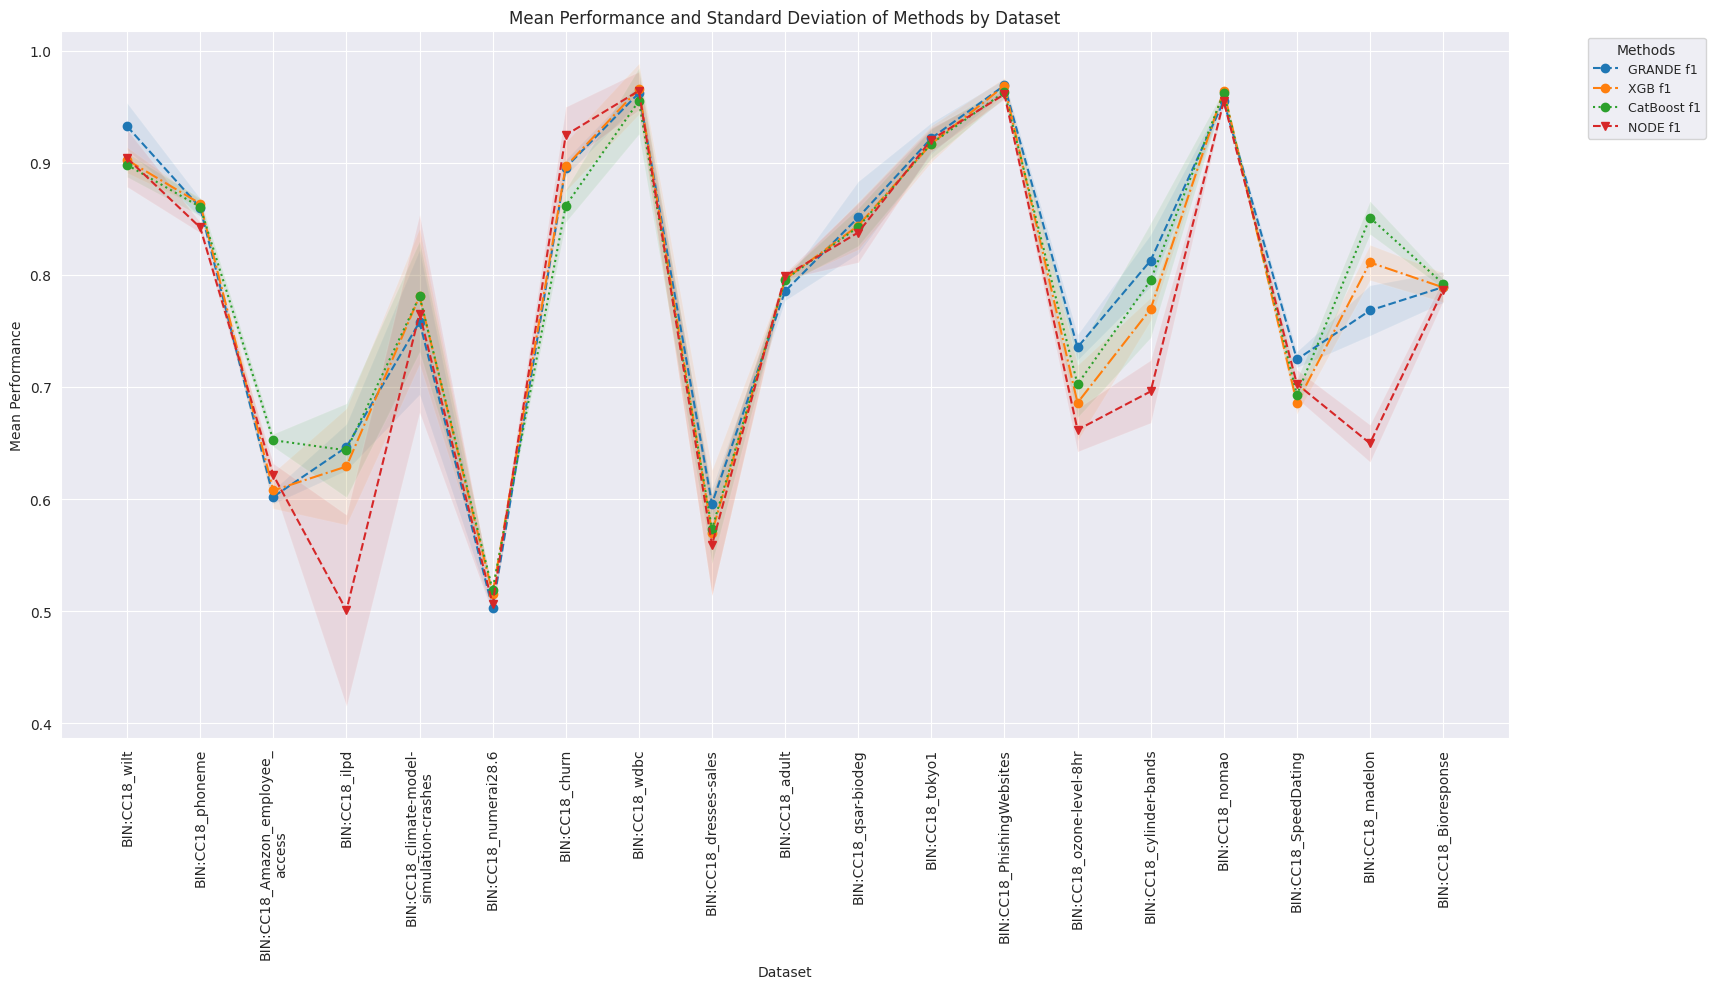

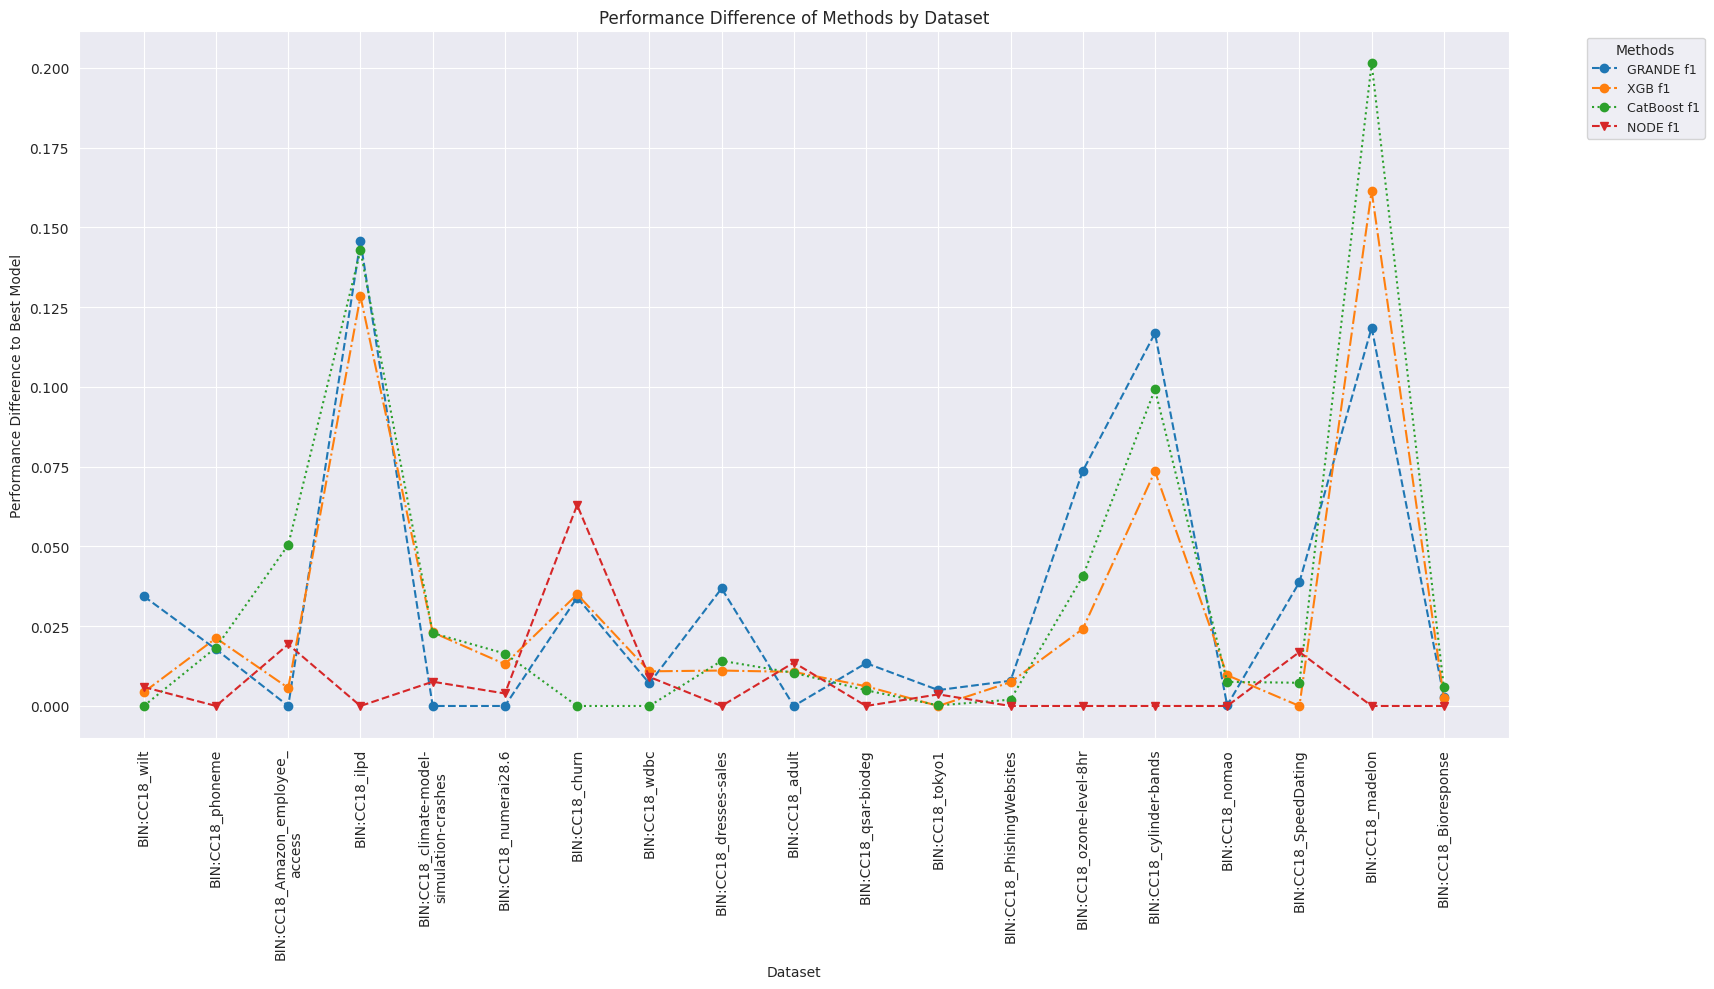

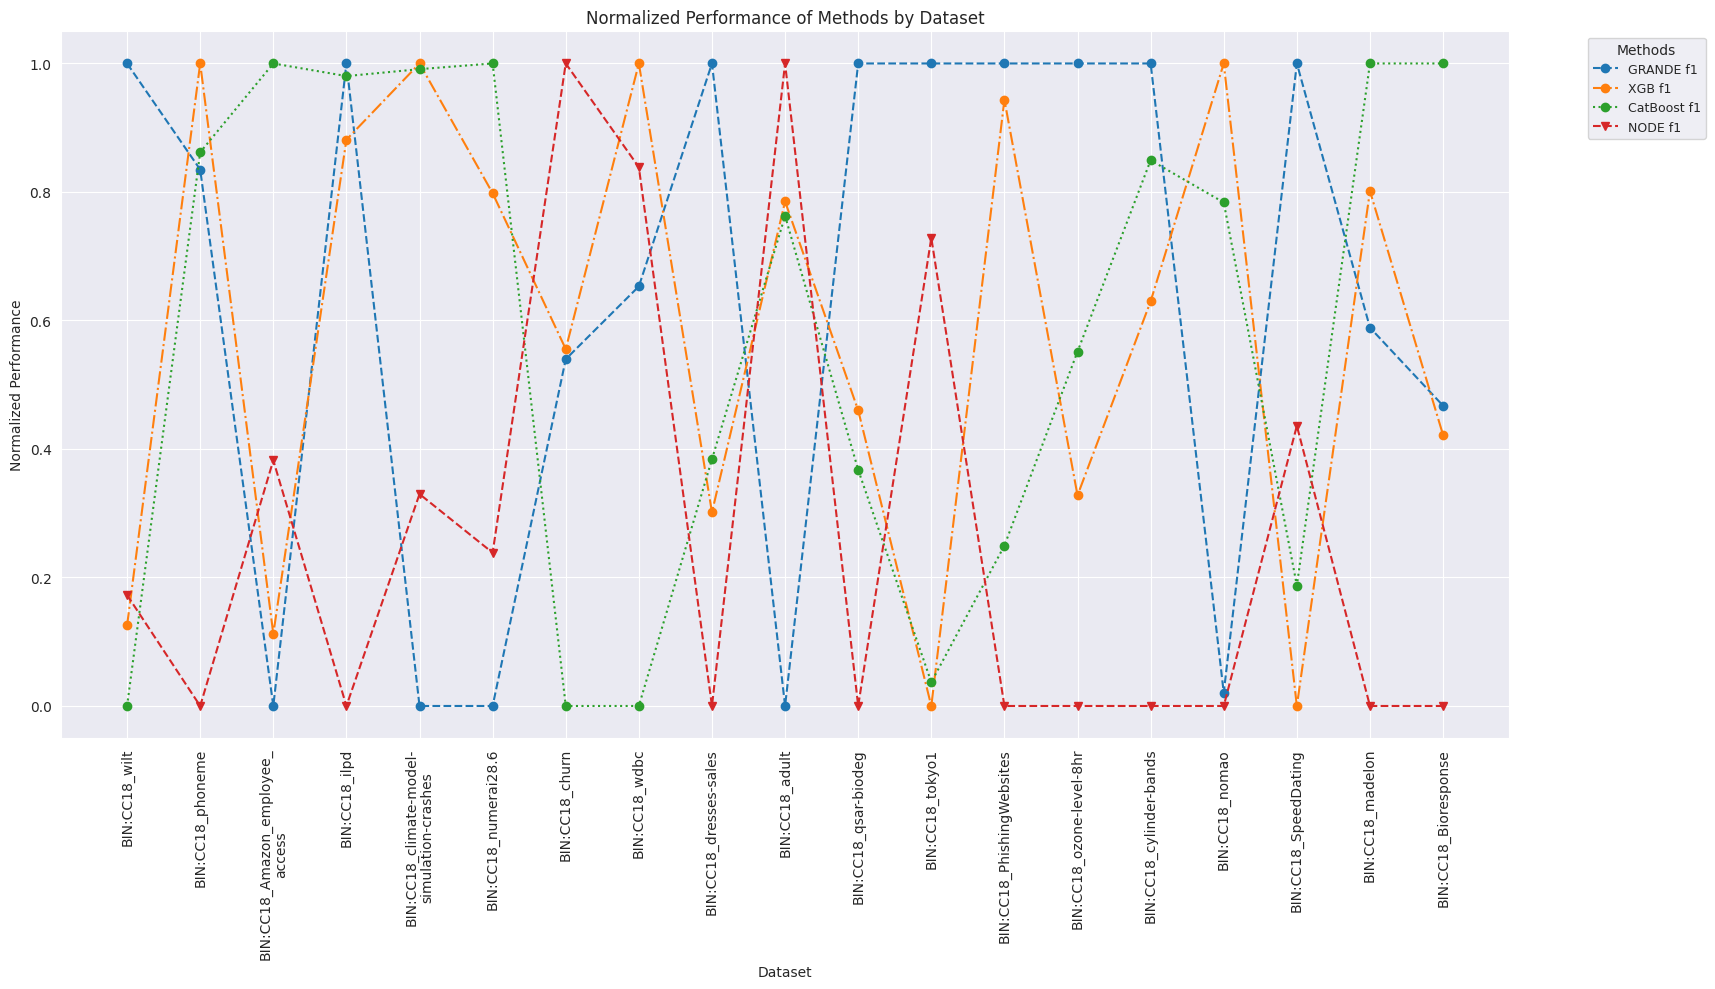

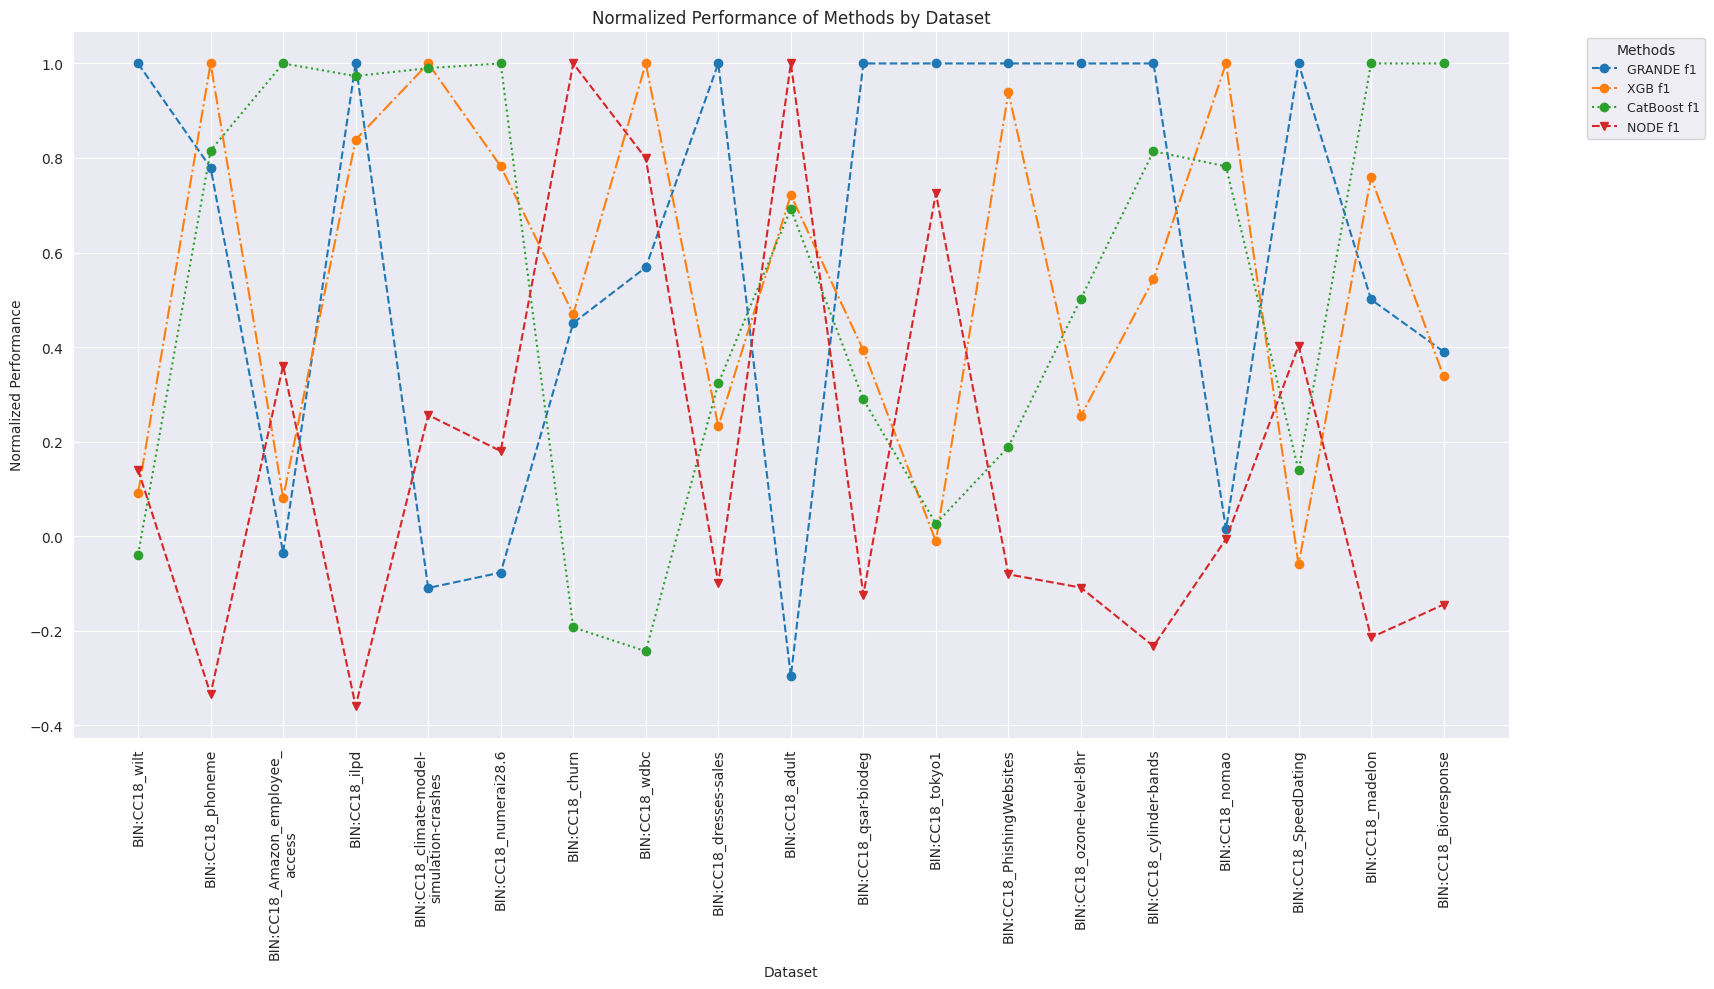

In [14]:
plot_methods_performance_with_std(result_dataframe_dict_features['test'][eval_metric][:-3])
plot_methods_performance_diff(result_dataframe_dict_features['test'][eval_metric][:-3])
plot_methods_performance_norm(result_dataframe_dict_features['test'][eval_metric][:-3])
plot_methods_performance_norm_affine(result_dataframe_dict_features['test'][eval_metric][:-3], quantile=quantile, clip_negative=clip_negative)

In [15]:
from numba import cuda 
if config['computation']['use_gpu']:
    device = cuda.get_current_device()
    device.reset()